<a href="https://colab.research.google.com/github/saeedzou/Adaptive-Filters/blob/main/coco_people_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import os
import cv2
import numpy as np
import torch
from pycocotools.coco import COCO
from torchvision import transforms
from torch.utils.data import Dataset


In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2014/COCO_train2014_000000408557.jpg  
 extracting: train2014/COCO_train2014_000000013714.jpg  
 extracting: train2014/COCO_train2014_000000194043.jpg  
 extracting: train2014/COCO_train2014_000000219859.jpg  
 extracting: train2014/COCO_train2014_000000278135.jpg  
 extracting: train2014/COCO_train2014_000000141015.jpg  
 extracting: train2014/COCO_train2014_000000280923.jpg  
 extracting: train2014/COCO_train2014_000000200024.jpg  
 extracting: train2014/COCO_train2014_000000435713.jpg  
 extracting: train2014/COCO_train2014_000000249993.jpg  
 extracting: train2014/COCO_train2014_000000424160.jpg  
 extracting: train2014/COCO_train2014_000000142761.jpg  
 extracting: train2014/COCO_train2014_000000532668.jpg  
 extracting: train2014/COCO_train2014_000000564904.jpg  
 extracting: train2014/COCO_train2014_000000346384.jpg  
 extracting: train2014/COCO_train2014_000000560934.jpg  
 extracting: train2014/COCO_train2014

In [3]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import torch
# Load the annotations file
annFile = '/content/annotations/instances_train2014.json'
coco = COCO(annFile)

# Get the list of image IDs that have people in them
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)
# create a dataset of images with people in them
dataset = []
for imgId in imgIds:
    img = coco.loadImgs(imgId)[0]
    dataset.append(img)
# count the number of images in the dataset
print(len(dataset))

loading annotations into memory...
Done (t=16.33s)
creating index...
index created!
45174


In [4]:
import json
import os
import cv2
import numpy as np
import torch
from pycocotools.coco import COCO
from torchvision import transforms
from torch.utils.data import Dataset

class COCOPeopleDataset(Dataset):
    def __init__(self, annFile,captions_path, transforms=None):
        self.coco = COCO(annFile)
        self.coco_caps = COCO(captions_path)
        self.imgIds = self.coco.getImgIds(catIds=self.coco.getCatIds(catNms=['person']))
        self.transforms = transforms

    def __len__(self):
        return len(self.imgIds)

    def __getitem__(self, idx):
        img = self.coco.loadImgs(self.imgIds[idx])[0]
        path = os.path.join('train2014/', img['file_name'])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0
        # load image captions
        annIds = self.coco_caps.getAnnIds(imgIds=img['id'])
        anns = self.coco_caps.loadAnns(annIds)
        #first caption
        caption = anns[0]['caption']

        if self.transforms is not None:
            image = self.transforms(image)
        return image,caption

# Apply desired transformations
transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Create the dataset
dataset = COCOPeopleDataset(annFile='/content/annotations/instances_train2014.json',captions_path='/content/annotations/captions_train2014.json', transforms=transforms)

loading annotations into memory...
Done (t=15.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [ ]:
dataset[0]

(tensor([[[-0.2746, -0.2468, -0.1754,  ..., -0.1067, -0.1580, -0.1961],
          [-0.2623, -0.1841, -0.2390,  ..., -0.1442, -0.1328, -0.1467],
          [-0.2363, -0.3208, -0.2348,  ..., -0.1279, -0.1063, -0.1337],
          ...,
          [ 0.0185,  0.4134,  0.2769,  ...,  0.8928,  2.0578,  2.2085],
          [ 0.1481,  0.3400,  0.1771,  ...,  0.3087,  2.1374,  2.1528],
          [ 0.1614,  0.3503,  0.1200,  ...,  0.3215,  1.3903,  2.1674]],
 
         [[ 0.5814,  0.6078,  0.5953,  ...,  0.6542,  0.6491,  0.6538],
          [ 0.5870,  0.6164,  0.6492,  ...,  0.6540,  0.6639,  0.6458],
          [ 0.6194,  0.6512,  0.6256,  ...,  0.6932,  0.6733,  0.6556],
          ...,
          [-1.0267, -0.5453, -0.6259,  ...,  0.9702,  2.3144,  2.4035],
          [-0.9461, -0.6091, -0.8932,  ...,  0.3040,  2.3761,  2.3811],
          [-0.9097, -0.7270, -1.0058,  ...,  0.3369,  1.5904,  2.4152]],
 
         [[ 1.5349,  1.5263,  1.5642,  ...,  1.5150,  1.5054,  1.4732],
          [ 1.5602,  1.5615,

In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

torch.Size([32, 3, 224, 224])
A woman riding a snowboard down a snow covered slope.


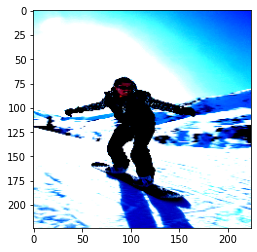

In [6]:
for i, (images, captions) in enumerate(dataloader):
    print(images.shape)
    print(captions[0])
    # un
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    break